Successfully processed w2_35cntrl:
GrowthRates 6.2 ©2022 All Rights Reserved Bellingham Research Institute.


	1.	Input file is already in Standard format
	2	Biotek Eon
	3.	Biotek PowerWave HT
	4.	Perkin Elmer
	5.	Bioscreen
	6.	Spark Tecan
	7.	SpectraMax or SpectraMaxM2
	8.	SpectroStarNano
	9.	Tecan
	10.	FLUOstar Omega
	11.	SpectraMaxPlus384 or M5
	12.	Biotek Cytation5 or Epoch2
	13.	Tecan Infinite 200 Pro
	14.	Synergy HTX
	15.	Growth Profiler 960
	16	Cerillo Stratus.
	17	Thermofisher Varioskan-LUX.
	18	Biotek 800 TS.

	0.	None of the above.


Pick your plate reader from the menu above and enter the corresponding number

You have chosen Standard.  Is that correct? (Y or N) 

The format is Standard.

Successfully processed w3_rep2:
GrowthRates 6.2 ©2022 All Rights Reserved Bellingham Research Institute.


	1.	Input file is already in Standard format
	2	Biotek Eon
	3.	Biotek PowerWave HT
	4.	Perkin Elmer
	5.	Bioscreen
	6.	Spark Tecan
	7.	SpectraMax or SpectraMaxM2
	8.	SpectroStarNano
	9.

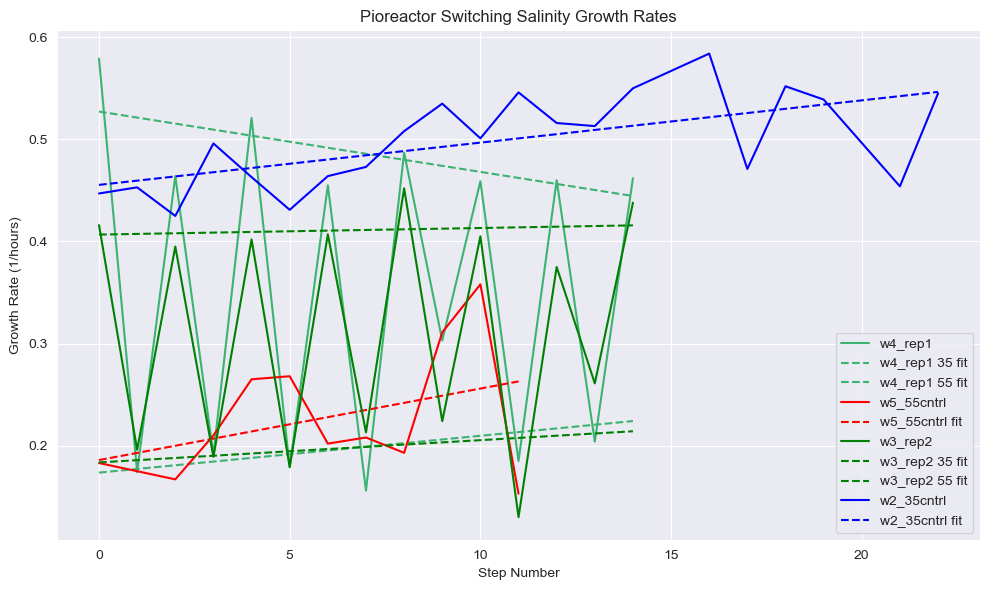

In [13]:
import subprocess
import pandas as pd
import glob
import os
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Paths and configurations
GROWTH_RATES_EXEC_PATH = '/Applications/GrowthRates_6.2.1/GrowthRates'
OUTPUT_DIR = './grme/jackson/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Utility functions
def unzip_and_rename_csv(zip_file, extract_folder=None, new_name="latest_od_data.csv"):
    """Extracts a CSV from a ZIP file, renames it, and returns its path."""
    extract_folder = extract_folder or os.path.dirname(zip_file)
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
        csv_file = next((os.path.join(extract_folder, f) for f in zip_ref.namelist() if f.lower().endswith('.csv')), None)
    if not csv_file:
        raise FileNotFoundError("No CSV found in the ZIP.")
    renamed_path = os.path.join(extract_folder, new_name)
    os.rename(csv_file, renamed_path)
    return renamed_path

def preprocess_csv(file_path):
    """Load and preprocess CSV data."""
    return (
        pd.read_csv(file_path)
        .rename(columns={"od_reading": "OD600", "timestamp_localtime": "Time", "pioreactor_unit": "Unit"})
        .drop(columns=["experiment", "timestamp", "angle", "channel"])
        .assign(Time=lambda d: pd.to_datetime(d["Time"]))
    )

def apply_transformations(df, transformations):
    """Apply unit-specific transformations to the DataFrame."""
    for unit, (slope, intercept) in transformations.items():
        if unit in df.columns:
            df[unit] = df[unit] * slope + intercept
    return df

# Load the latest CSV or extract from ZIP
csv_files = glob.glob(os.path.expanduser('~/Downloads/*.csv'))
latest_csv = max(csv_files, key=os.path.getmtime) if csv_files else unzip_and_rename_csv('./od_logs/latest_od_data.zip')
exp1_csv = unzip_and_rename_csv('./od_logs/exp1.zip', new_name="exp1.csv")

# Preprocess and combine data
df = pd.concat([preprocess_csv(latest_csv), preprocess_csv(exp1_csv)])
df = df.drop_duplicates(subset=['Time', 'Unit'])
df = df.pivot(index='Time', columns='Unit', values='OD600')
df.columns.name = None

# Apply transformations and filter data
TRANSFORMATIONS = {
    'worker2': (1.3486, 0.077),
    'worker3': (2.0737, 0.077),
    'worker4': (2.2043, 0.077),
    'worker5': (1.1695, 0.077)
}
df = apply_transformations(df, TRANSFORMATIONS)
df = df[df < 0.45][100:]
df = df.rename(columns={
    "worker2": "w2_35cntrl",
    "worker3": "w3_rep2",
    "worker4": "w4_rep1",
    "worker5": "w5_55cntrl"
})

# Generate worker-specific data and process GrowthRates
for worker in df.columns:
    worker_file = os.path.join(OUTPUT_DIR, f"{worker}.txt")
    new_data = pd.DataFrame()

    # Resample and identify subculture points
    data = df[[worker]].resample('30min').mean()
    subculture_points = (
        data.loc[data[worker].rolling(3).std().abs() > 0.02]
        .groupby(data.loc[data[worker].rolling(3).std().abs() > 0.02].index.date)
        .idxmin()
        .reset_index(drop=True)
        .to_numpy()
        .flatten()
    )

    # Process each step
    data = df[[worker]].resample('10min').mean()
    start_index = data.index[0]

    for i, point in enumerate(subculture_points):
        current_step = data.loc[start_index:point]
        if not current_step.empty:
            current_step = current_step.iloc[:-6]
            if not current_step.empty:
                current_step.index = ((current_step.index - current_step.index[0]).total_seconds() / 60).astype(int)
                current_step.columns = [f'{worker}_S{i+1}']
                new_data = pd.concat([new_data, current_step], axis=1)
        start_index = point

    # Interpolate and save
    new_data.index.name = 'Min'
    new_data = new_data.interpolate(method='linear', limit_area='inside').round(4).fillna(0)
    new_data.to_csv(worker_file, sep='\t')

    # Run GrowthRates
    try:
        command = [GROWTH_RATES_EXEC_PATH, "-i", os.path.relpath(worker_file), "-b", "0.077"]
        process = subprocess.Popen(command, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        stdout, stderr = process.communicate(input="1\nY\n")
        if process.returncode == 0:
            print(f"Successfully processed {worker}:\n{stdout}")
        else:
            print(f"Error processing {worker}:\n{stderr}")
    except Exception as e:
        print(f"Error running GrowthRates for {worker}: {e}")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
palette = {'w2_35cntrl': "blue", 'w5_55cntrl': "red", 'w3_rep2': "green", 'w4_rep1': "mediumseagreen"}
replicates = ['w3_rep2', 'w4_rep1']
controls = ['w2_35cntrl', 'w5_55cntrl']

for filepath in glob.glob(os.path.expanduser('grme/jackson/*.summary')):
    temp_df = pd.read_csv(filepath, sep='\t', header=2, usecols=['Well', 'min', 'hours', 'R', 'Max OD', 'lag time (minutes)'])
    temp_df.rename(columns={'hours': 'Growth Rate (1/hours)'}, inplace=True)
    unit_name = os.path.basename(filepath).split('.')[0]

    # Remove outliers for specific units
    if unit_name == 'w2_35cntrl':
        temp_df.drop([15, 20], inplace=True)

    sns.lineplot(data=temp_df, x=temp_df.index, y='Growth Rate (1/hours)', ax=ax, color=palette[unit_name], label=unit_name)

    # Add best-fit lines
    x = temp_df.index
    y = temp_df['Growth Rate (1/hours)']
    if unit_name in replicates:
        if len(x[::2]) > 1:
            m, b = np.polyfit(x[::2], y[::2], 1)
            ax.plot(x, m * x + b, color=palette[unit_name], linestyle='dashed', label=f'{unit_name} 35 fit')
        if len(x[1::2]) > 1:
            m, b = np.polyfit(x[1::2], y[1::2], 1)
            ax.plot(x, m * x + b, color=palette[unit_name], linestyle='dashed', label=f'{unit_name} 55 fit')
    elif unit_name in controls and len(x) > 1:
        m, b = np.polyfit(x, y, 1)
        ax.plot(x, m * x + b, color=palette[unit_name], linestyle='dashed', label=f'{unit_name} fit')

plt.xlabel('Step Number')
plt.ylabel('Growth Rate (1/hours)')
plt.title('Pioreactor Switching Salinity Growth Rates')
plt.tight_layout()
plt.legend(loc='lower right')
plt.show()